# Semantic Segmentation

![](https://github.com/oseledets/dl2023/blob/main/seminars/seminar-5/doge_segmentation.png?raw=1)

## Unet architecture

![](https://github.com/oseledets/dl2023/blob/main/seminars/seminar-5/unet.png?raw=1)

In [3]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gdown

In [2]:
gdown.download(url="https://drive.google.com/file/d/1kiR9pPP3gIqoyT9bWUnA0rgZuRTiUv7q/view?usp=share_link", output="./unet_dict.pt", quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1kiR9pPP3gIqoyT9bWUnA0rgZuRTiUv7q
To: /content/unet_dict.pt
100%|██████████| 124M/124M [00:01<00:00, 124MB/s]


'./unet_dict.pt'

In [10]:
class Encoder_Block(torch.nn.Module):
  def __init__(self, inp_channels, out_channels):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(inp_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
    self.pooling = nn.MaxPool2d(2)
  def forward(self,x):
    int_out = self.model(x)
    return self.pooling(int_out), int_out

class Decoder_Block(torch.nn.Module):
  def __init__(self, inp_channels, out_channels):
    super().__init__()
    self.upsample = nn.ConvTranspose2d(inp_channels, out_channels, kernel_size=2, stride=2)
    self.model = nn.Sequential(
        nn.Conv2d(inp_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
        
  def forward(self, x, enc_x):
    x = self.upsample(x)
    x = torch.cat([x, enc_x], dim=1)
    return self.model(x)

# Let's check our implementation

In [11]:
enc = Encoder_Block(64, 128)
dec = Decoder_Block(256, 128)
inp = torch.randn(1, 64, 64, 64)
x, enc_x = enc(inp)

assert x.shape == (1, 128, 32, 32), "correct encoder implementation"

inp = torch.randn(1, 256, 32, 32)
x = dec(inp, enc_x)

assert x.shape == (1, 128, 64, 64), "correct decoder implementation"

In [12]:
class Unet(nn.Module):
  def __init__(self, inc, outc, hidden_size=64):
    super().__init__()
    self.Encoder = nn.ModuleList([
        Encoder_Block(inc, hidden_size),
        Encoder_Block(hidden_size, hidden_size*2),
        Encoder_Block(hidden_size*2, hidden_size*4),
        Encoder_Block(hidden_size*4, hidden_size*8)
    ])
    self.bottleneck = nn.Sequential(
        nn.Conv2d(hidden_size*8, hidden_size*16, kernel_size=1),
        nn.BatchNorm2d(hidden_size*16),
        nn.ReLU(),
        nn.Conv2d(hidden_size*16, hidden_size*16, kernel_size=1),
        nn.BatchNorm2d(hidden_size*16),
        nn.ReLU()
    )
    self.Decoder = nn.ModuleList([
        Decoder_Block(hidden_size*16, hidden_size*8),
        Decoder_Block(hidden_size*8, hidden_size*4),
        Decoder_Block(hidden_size*4, hidden_size*2),
        Decoder_Block(hidden_size*2, hidden_size)
    ])
    self.last_layer = nn.Conv2d(hidden_size, outc, kernel_size=3, padding="same")
  def forward(self, x):
    enc_xs = []
    for module in self.Encoder:
      x, enc_x = module(x)
      enc_xs.append(enc_x)
    
    enc_xs = enc_xs[::-1]
    x = self.bottleneck(x)

    for i, module in enumerate(self.Decoder):
      x = module(x, enc_xs[i])
    return self.last_layer(x)

## Check that your implementation works correctly

In [13]:
unet = Unet(3,11)

assert unet(torch.randn(1, 3, 128, 128)).shape == (1, 11, 128, 128), "check your implementation"

## Let's start working with data

In [14]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])
def class_split(data,n=3):
  data = np.array(data)
  res = []
  for i in range(1,1+n):
    mask = np.zeros_like(data)
    mask[data==i] = 1.
    res.append(mask[None])
  return torch.from_numpy(np.concatenate(res,axis=0)).to(torch.float)

target_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    class_split
])
dataset = torchvision.datasets.OxfordIIITPet("./data", split="trainval", target_types="segmentation", download=True, transform=transform, target_transform=target_transform)

100%|██████████| 791918971/791918971 [00:54<00:00, 14581104.37it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7267711.12it/s] 


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet(3, 3).to(device)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)

In [19]:
from tqdm import tqdm

In [20]:
def train(model, dataloader, optimizer, loss_func=nn.CrossEntropyLoss(), epochs=5):
  for i in range(epochs):
    for x, y in tqdm(dataloader):
      x = x.to(device)
      y = y.to(device)
      out = model(x)
      loss = loss_func(out, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print(i)

In [21]:
train(unet, dataloader, optimizer, epochs=10)

100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


0


100%|██████████| 115/115 [00:45<00:00,  2.55it/s]


1


100%|██████████| 115/115 [00:45<00:00,  2.50it/s]


2


100%|██████████| 115/115 [00:45<00:00,  2.53it/s]


3


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


4


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


5


100%|██████████| 115/115 [00:45<00:00,  2.53it/s]


6


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


7


100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


8


100%|██████████| 115/115 [00:45<00:00,  2.51it/s]

9


In [24]:
iou = []
for x, y in tqdm(dataloader):
  y_hat = (nn.Softmax(dim=1)(unet(x.to(device))) > 0.5).to(torch.float)
  intersection = y_hat * y.to(device)
  union = (y_hat + y.to(device)).clamp(0, 1)
  iou.append(intersection.sum() / union.sum())

100%|██████████| 115/115 [00:45<00:00,  2.55it/s]


In [29]:
iou = [item.item() for item in iou]

In [30]:
round(np.mean(iou)*100, 1)

78.4

In [31]:
!wget -nv "https://fikiwiki.com/uploads/posts/2022-02/1644990866_45-fikiwiki-com-p-prikolnie-kartinki-pro-zhivotnikh-47.png"

2023-04-04 12:22:29 URL:https://fikiwiki.com/uploads/posts/2022-02/1644990866_45-fikiwiki-com-p-prikolnie-kartinki-pro-zhivotnikh-47.png [1205459/1205459] -> "1644990866_45-fikiwiki-com-p-prikolnie-kartinki-pro-zhivotnikh-47.png" [1]


In [32]:
from PIL import Image
img = Image.open("/content/1644990866_45-fikiwiki-com-p-prikolnie-kartinki-pro-zhivotnikh-47.png")

In [33]:
img = transform(img)[:3][None].to(device)
mask = unet(img)[0]

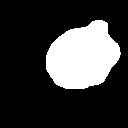

In [35]:
transforms.ToPILImage()((torch.nn.Softmax(dim=0)(mask)[0:1].detach().cpu() > 0.5).to(torch.float))

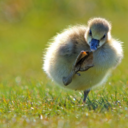

In [36]:
transforms.ToPILImage()(img[0].detach().cpu()/2+0.5)